# Glauber on infinite random $k$-regular graph
Compute magnetization in the thermodynamic limit $N\to\infty$ for random $k$-regular graphs with $k=8$.

Compare the steady-state magnetization with its equilibrium value.

In [49]:
using MatrixProductBP, MatrixProductBP.Models
using Plots, Statistics
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
using LaTeXStrings
using Measurements: value;

In [50]:
include("../../telegram/notifications.jl");

In [51]:
T = 20         # final time
k = 3          # degree
m⁰ = 0.5       # magnetization at time zero

β = 100.0
J = -1.0
h = 0.0;

In [52]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [ ]:
matrix_sizes = [16, 20, 23]
maxiters = fill(8, length(matrix_sizes))
maxiters = [8, 10, 20]
iters = zeros(Int, length(maxiters))
tol = 1e-4
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol, damp=0.5)
end

In [ ]:
@telegram "antiferro zeroT damped";

In [ ]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

In [ ]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m = means(spin, bp);

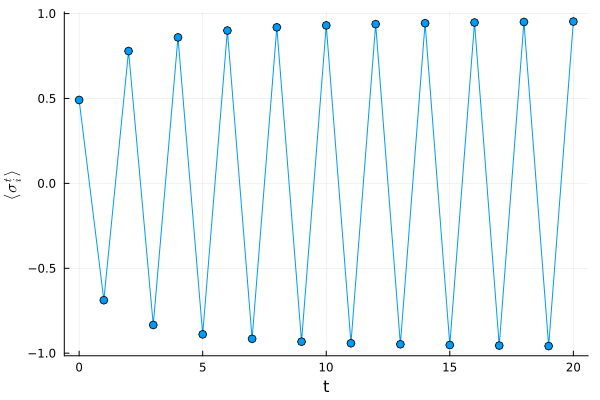

In [72]:
plot(0:T, mean(m), label="", ylabel=L"\langle \sigma_i^t\rangle", xlabel="t", m=:o)

In [ ]:
pb = pair_beliefs_as_mpem(bp)[1][1]
compress!(pb; svd_trunc=TruncBond(15))
mtu = marginals_tu(pb; Δtmax=1)
r = [expectation(spin, dropdims(sum(sum(mtu[t,t+1], dims=2), dims=3); dims=(2,3))) 
    for t in 1:T];

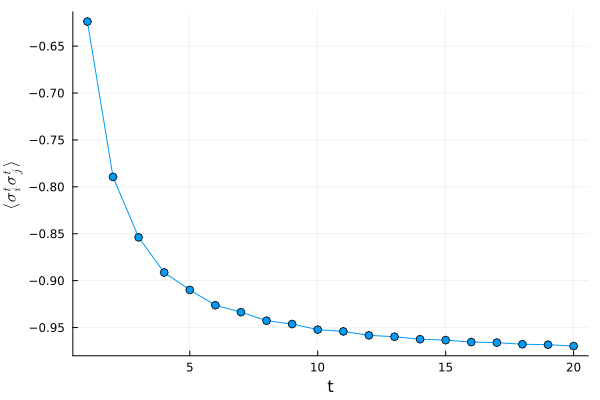

In [73]:
plot(1:T, r, label="", ylabel=L"\langle \sigma_i^t \sigma_j^t\rangle", xlabel="t", m=:o)

### Compare with Monte Carlo on finite graphs

In [75]:
using Graphs, IndexedGraphs, Statistics

N = 5*10^3
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
T_mc = 40
wᵢ_mc = fill(HomogeneousGlauberFactor(J, h, β), T_mc+1)
ϕᵢ_mc = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T_mc]
bp_mc = mpbp(IndexedBiDiGraph(g), fill(wᵢ_mc, N), fill(2,N), T_mc; ϕ = fill(ϕᵢ_mc, N))
sms = SoftMarginSampler(bp_mc);

In [76]:
sample!(sms, 10^3)
spin(x) = 3-2x
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:01:34


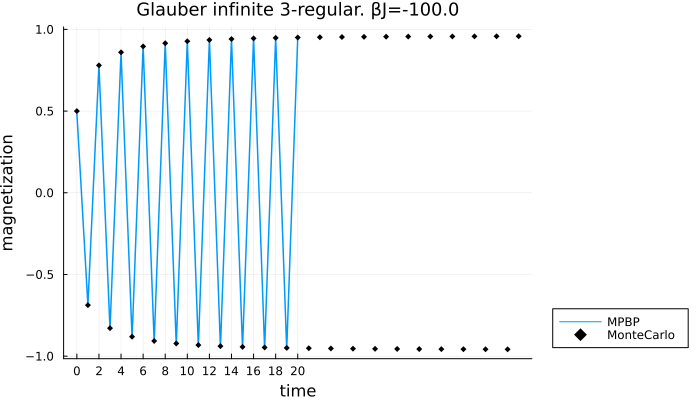

In [77]:
blue = theme_palette(:auto)[1]
skip_odd = false
step = skip_odd ? 2 : 1
pl = plot(0:step:T, m[1:step:end], xlabel="time", ylabel="magnetization", label="MPBP",
    size=(500,300), xticks=0:2:T, ms=3, title="Glauber infinite $k-regular. βJ=$(β*J)", titlefontsize=12,
    legend=:outerbottomright, msc=:auto, c=blue, lw=1.5)
# plot!(pl, 0:T, sample(m_mc, 10^2), label=permutedims(["samples"; fill("", 10^2-1)]), c=:gray, la=0.1)
plot!(pl, 0:step:T_mc, mean(m_mc)[1:step:end], label="MonteCarlo", c=:black, m=:diamond, ms=3, msc=:auto, st=:scatter)

plot!(pl, size=(700, 400))

In [78]:
import Measurements: Measurement, ±
import StatsBase
function pair_marginals_ttp1(sms::SoftMarginSampler; showprogress::Bool=true) 
    @unpack bp, X, w = sms
    g = bp.g
    T = getT(bp); E = ne(g)
    marg = [[zeros(Measurement, nstates(bp,i), nstates(bp,j)) for t in 0:T] for (i,j,id) in edges(g)]
    @assert all(>=(0), w)
    wv = StatsBase.weights(w)
    nsamples = length(X)
    prog = ProgressMeter.Progress(E, desc="Marginals from Soft Margin"; dt=showprogress ? 0.1 : Inf)
    x = zeros(Int, length(X))

    for (i,j,id) in edges(g)
        linear = LinearIndices((1:nstates(bp,i), 1:nstates(bp,j)))
        for t in 1:T
            x .= [linear[xx[i, t],xx[j,t+1]] for xx in X]
            mijt_avg_linear = StatsBase.proportions(x, nstates(bp,i)*nstates(bp,j), wv)
            mijt_avg = reshape(mijt_avg_linear, linear.indices...)
            # avoid numerical errors yielding probabilities > 1
            mijt_avg = map(x -> x≥1 ? 1 : x, mijt_avg)
            mijt_var = mijt_avg .* (1 .- mijt_avg) ./ nsamples
            marg[id][t] .= mijt_avg .± sqrt.( mijt_var )
        end
        ProgressMeter.next!(prog)
    end

   return marg
end

pair_marginals_ttp1 (generic function with 1 method)

In [79]:
pb_mc = pair_marginals_ttp1(sms);

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:44


In [80]:
r_mc = [[expectation(spin, value.(bb)) for bb in b] for b in pb_mc];

In [87]:
m_eq, r_eq, e_eq = equilibrium_observables(RandomRegular(k), J; β, h, damp=0.5, init=0.0)

(m = 0.0, r = -1.0, e = -1.5)

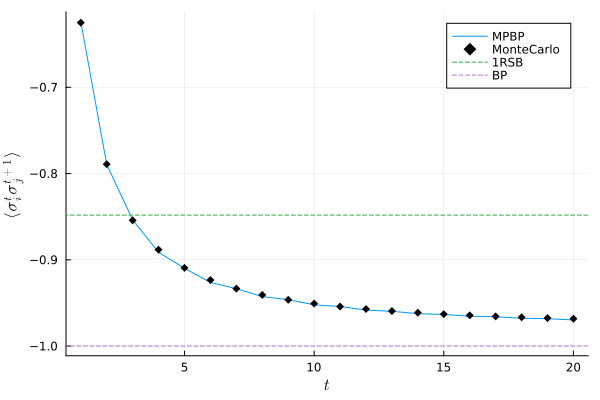

In [127]:
plot(1:T, r, label="MPBP", ylabel=L"\langle \sigma_i^t \sigma_j^{t+1}\rangle", xlabel=L"t")
scatter!(1:T, mean(r_mc)[1:T], label="MonteCarlo", c=:black, m=:diamond, legend=:bottomright)
hline!([-1.27231/(k/2)], ls=:dash, label="1RSB", legend=:topright)
hline!([r_eq], ls=:dash, label="BP", legend=:topright)

In [92]:
c = autocovariances(bp);

In [125]:
c_mc_ = autocovariances(spin, sms)
c_mc = [[value(x) for x in xx] for xx in c_mc_];

Autocorrelations from Soft Margin 100%|██████████████████| Time: 0:15:10
Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:16


In [93]:
plot_autocovs(args...; kw...) = plot_autocovs!(plot(), args...; kw...)
function plot_autocovs!(pl, c; skip_even=false, T=size(c,1)-1, ΔT=1.0, 
        us=0:(2*floor(Int, T/10)):T, cg = cgrad(:matter, length(us)+1, categorical=true), 
        kw...)
    step = skip_even ? 2 : 1
    ylabel = L"\langle x_{i}^t x_{i}^{s}\rangle-\langle x_{i}^t\rangle\langle x_{i}^{s}\rangle"
    xlabel = L"t-s"
    plot!(pl; xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, (u:-step:1).*ΔT, c[(0:step:u-1) .+ 1,u+1], label="t=$(Int(u*ΔT))", #label="t+Δt=$(Int(u*ΔT))", 
            c=cg[j+1], msc=:auto; kw...) 
    end
    pl
end 

plot_autocovs! (generic function with 1 method)

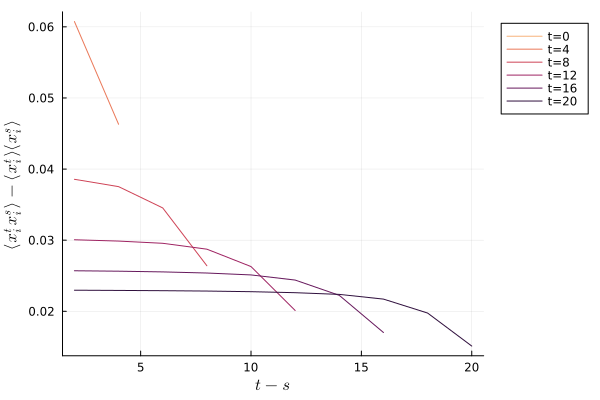

In [128]:
skip_even = true
pl = plot_autocovs(mean(c); skip_even)
# plot_autocovs!(pl, mean(c_mc); st=:scatter, skip_even)

In [ ]:
jldsave("plot_data/glauber_antiferro_zeroT.jld2"; T, J, k, β, N, m⁰, r, r_mc, c);